<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike, Union
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import stats
import time_of_emergence_calc as toe_calc
import time_of_emergence_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

In [3]:
xr.set_options(display_expand_data=False)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [5]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [6]:
# client.close()

In [7]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=20)
client

 - State start
 - Found stale lock file and directory '/jobfs/131294173.gadi-pbs/dask-scratch-space/scheduler-f5ldfn1g', purging
 -   Scheduler at:     tcp://127.0.0.1:41991
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:44011'
 -         Start Nanny at: 'tcp://127.0.0.1:44375'
 -         Start Nanny at: 'tcp://127.0.0.1:38693'
 -         Start Nanny at: 'tcp://127.0.0.1:39985'
 -         Start Nanny at: 'tcp://127.0.0.1:40629'
 -         Start Nanny at: 'tcp://127.0.0.1:39309'
 -         Start Nanny at: 'tcp://127.0.0.1:39513'
 -         Start Nanny at: 'tcp://127.0.0.1:41969'
 -         Start Nanny at: 'tcp://127.0.0.1:44875'
 -         Start Nanny at: 'tcp://127.0.0.1:41559'
 -         Start Nanny at: 'tcp://127.0.0.1:39457'
 -         Start Nanny at: 'tcp://127.0.0.1:41223'
 -         Start Nanny at: 'tcp://127.0.0.1:36173'
 -         Start Nanny at: 'tcp://127.0.0.1:37655'
 -         Start Nanny at: 't

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 20
Total threads: 20,Total memory: 496.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41991,Workers: 20
Dashboard: /proxy/8787/status,Total threads: 20
Started: Just now,Total memory: 496.00 GiB
Comm: tcp://127.0.0.1:35697,Total threads: 1
Dashboard: /proxy/41695/status,Memory: 24.80 GiB
Nanny: tcp://127.0.0.1:44011,


 - Register worker <WorkerState 'tcp://127.0.0.1:37949', name: 21, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:37949
 - Starting established connection to tcp://127.0.0.1:56794
 - Register worker <WorkerState 'tcp://127.0.0.1:34399', name: 23, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:34399
 - Starting established connection to tcp://127.0.0.1:56806
 - Register worker <WorkerState 'tcp://127.0.0.1:41041', name: 25, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:41041
 - Starting established connection to tcp://127.0.0.1:56812
 - Register worker <WorkerState 'tcp://127.0.0.1:34747', name: 20, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:34747
 - Starting established connection to tcp://127.0.0.1:56826
 - Register worker <WorkerState 'tcp://127.0.0.1:41159', name: 26, status: init, memory: 0, processing: 

In [8]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [174]:
data_ds = open_data.open_best()
# data_ds = open_data.open_era5('t2m')

Opening best dataset from - /g/data/w40/ab2313/time_of_emergence/best/Land_and_Ocean_LatLong1_time_chunk.zarr
  -- overriding time to use cftime
  -- resampling to yearly mean


In [175]:
# data_ds = open_data.open_access()
# data_ds = open_data.open_gpcc()

# Precip variables must have extra selections
# data_ds = data_ds.resample(time='QS-DEC').sum().compute()
# data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [176]:
dataset_name, variable =  data_ds.dataset_name, data_ds.name
dataset_name, variable

('best', 'temperature')

In [177]:
data_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)> Size: 45MB
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[-2.09, ..., -2.09],
        ...,
        [ 2.25, ...,  2.24]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1kB 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

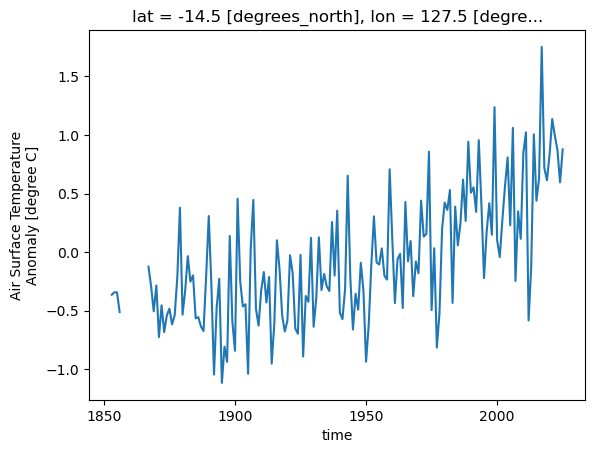

In [178]:
data_ds.sel(lat=-15, lon=127, method='nearest').plot()

In [179]:
reload(toe_const)

<module 'toe_constants' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/toe_constants.py'>

In [180]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.MODERN_PERIOD
base_period, base_period.start, base_period.end

(<YearRange.MODERN_PERIOD: (1959, 1989)>, 1959, 1989)

In [181]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'temperature' (time: 66, lat: 180, lon: 360)> Size: 17MB
array([[[ 0.25, ...,  0.25],
        ...,
        [ 0.68, ...,  0.68]],

       ...,

       [[-2.09, ..., -2.09],
        ...,
        [ 2.25, ...,  2.24]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 528B 1959-12-31 00:00:00 ... 2024-12-31 00:00:00
Attributes: (6)

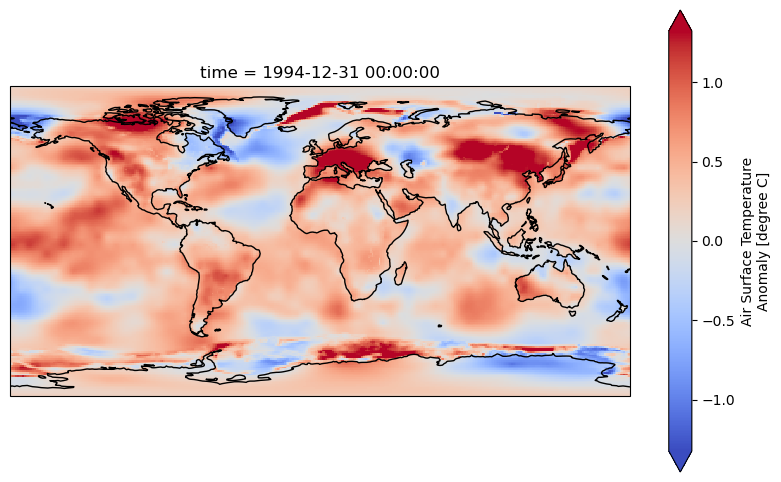

In [182]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [186]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*base_period.value)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 30, lat: 180, lon: 360)> Size: 8MB
array([[[ 0.25, ...,  0.25],
        ...,
        [ 0.68, ...,  0.68]],

       ...,

       [[ 1.6 , ...,  1.6 ],
        ...,
        [-0.34, ..., -0.34]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 240B 1959-12-31 00:00:00 ... 1988-12-31 00:00:00
Attributes: (6)

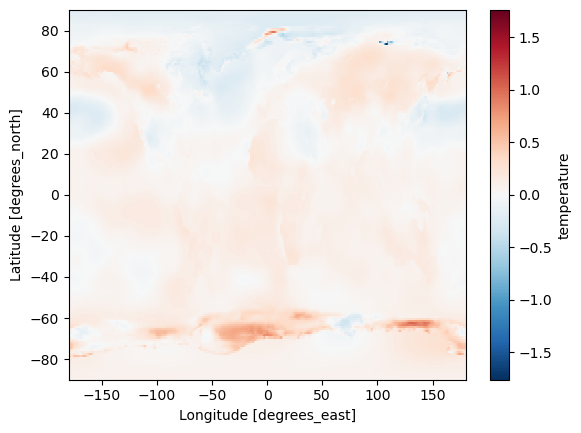

In [187]:
base_period_ds.mean(dim='time').plot()

In [188]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)> Size: 518kB
array([[1, ..., 1],
       ...,
       [1, ..., 1]])
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

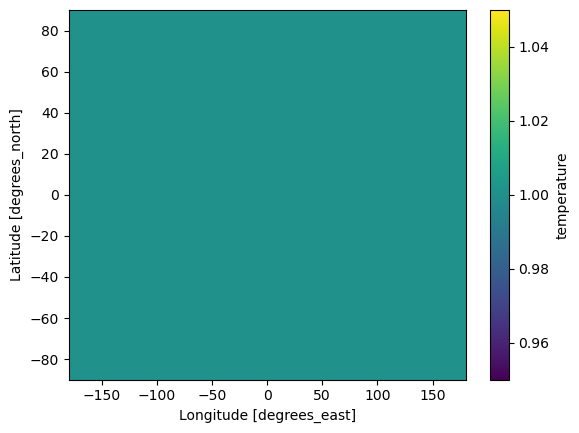

In [189]:
data_availability_mask.plot()

In [190]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [191]:
# Resetting the anomlies to 1850
data_ds = data_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [192]:
# P-value methods works better with a large cluster.
# Small chunks with large computation
client.cluster.scale(50)
sleep(7)

In [193]:
window = 20

In [194]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}
CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}

In [195]:
# Creting new datasets that has windown dimnsion for the rolling calculation
data_ds_window = (data_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [196]:
data_ds_window

<xarray.DataArray 'temperature' (time: 66, lat: 180, lon: 360, window_dim: 20)> Size: 342MB
dask.array<sliding_window_view, shape=(66, 180, 360, 20), dtype=float32, chunksize=(65, 60, 30, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 528B 1959-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [197]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

<h2 style='color: cyan'> Overlap Methods </h2>

In [198]:
reload(toe_calc)

<module 'time_of_emergence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emergence_calc.py'>

In [199]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_ds.values.flatten(), length=len(data_ds.time.values))

In [200]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

In [201]:
# # We want 25 steps betwen the 1st and 99th percentile
# bins_sudo = np.linspace(np.nanpercentile(data_ds.values, q=1), np.nanpercentile(data_ds.values, q=99), 25)
# bin_step = np.unique(np.diff(bins_sudo))[0]
# bins2 = np.arange(np.nanmin(data_ds.values), np.nanmax(data_ds.values), bin_step)
# bins2

In [202]:
# test_data  = data_ds.sel(lat=-38, lon=145, method='nearest').values

# bins, rel_freq = toe_calc.discrete_pdf(test_data)
# x_test, kde_test = toe_calc.create_kde(test_data, 

# fig, ax1 = plt.subplots(1, 1)
# ax2 = ax1.twinx()
# ax1.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
# ax2.plot(x_test, kde_test)

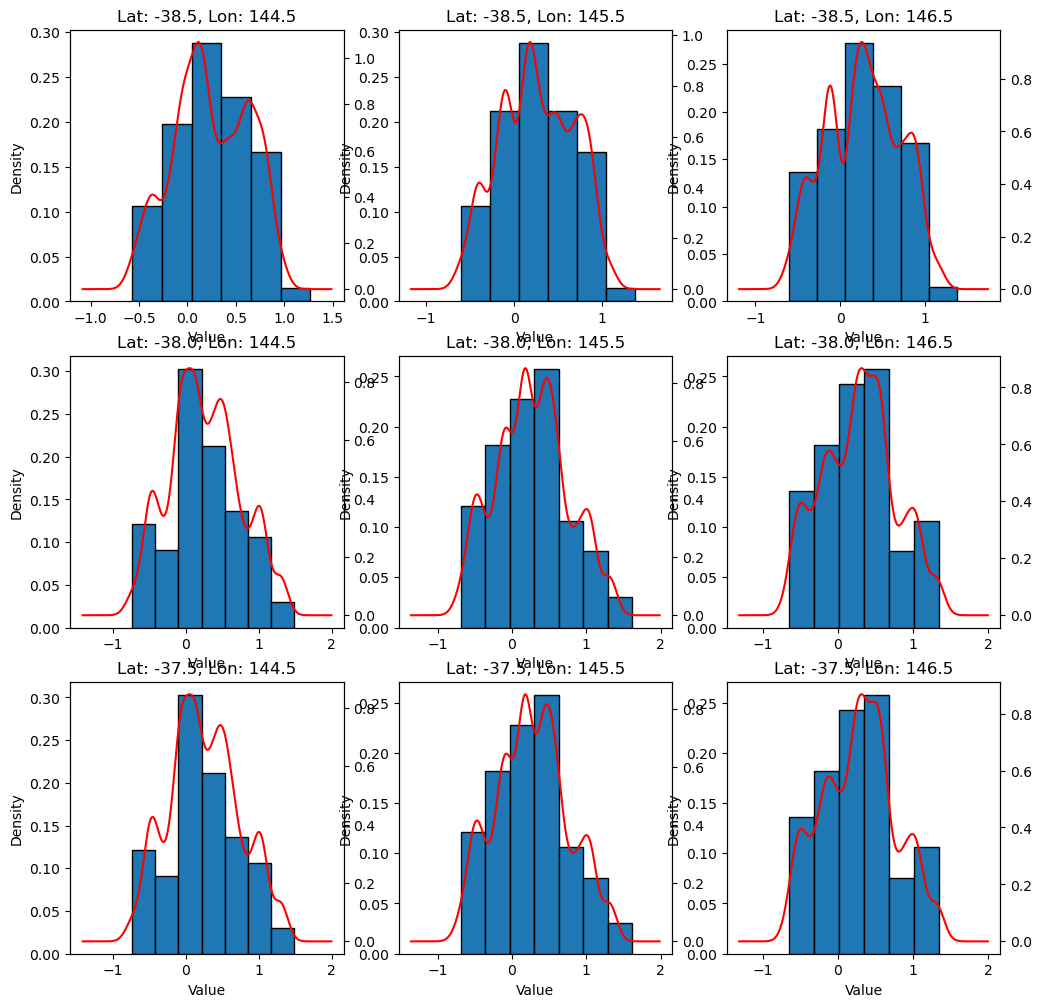

In [203]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        bins, rel_freq = toe_calc.discrete_pdf(test_data)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')

In [204]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score,
    data_ds_window,
    base_period_window_ds,
    kwargs={'bins': bins},
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute().sortby('lat')

CPU times: user 7.44 s, sys: 1.15 s, total: 8.58 s
Wall time: 13.2 s


In [205]:
%%time
frac_geom_ds = xr.apply_ufunc(
    toe_calc.fractional_geometric_area,
    data_ds_window,
    base_period_window_ds,
    kwargs = dict(method_kwargs=kde_kwargs),
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 47.3 s, sys: 8.86 s, total: 56.2 s
Wall time: 1min 38s


In [206]:
%%time
hellinger_ds = xr.apply_ufunc(
    toe_calc.hellinger_distance,
    data_ds_window,
    base_period_window_ds,
    kwargs = dict(method_kwargs=kde_kwargs),
    output_dtypes=float,
    **rolling_window_kwargs
    ).compute()

CPU times: user 46.7 s, sys: 8.64 s, total: 55.4 s
Wall time: 1min 36s


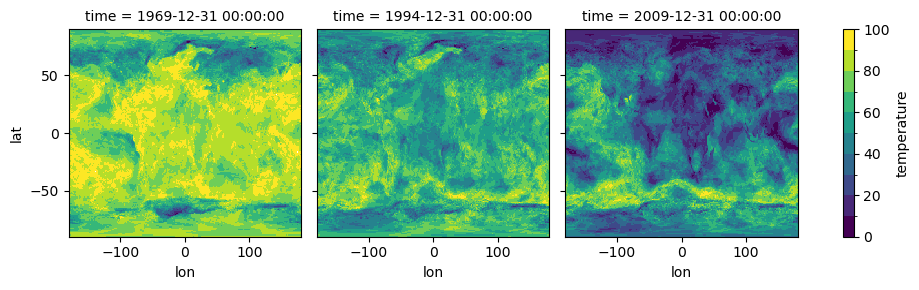

In [207]:
perkins_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

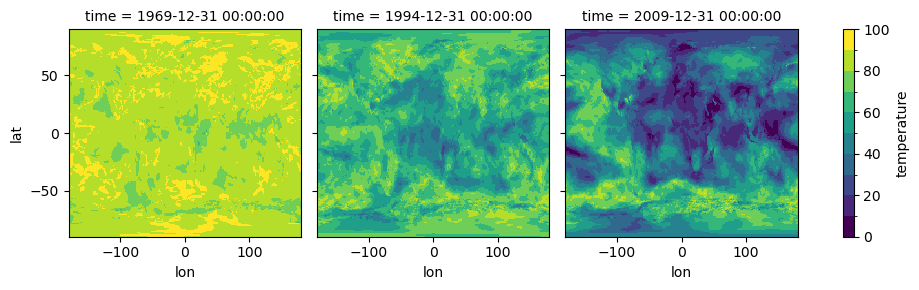

In [208]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [209]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [210]:
# %%time
# # Expected: 9 minutes 30 seconds
# ttest_ds = xr.apply_ufunc(
#         toe_calc.return_ttest_pvalue,
#         data_ds_window,
#         base_period_window_ds,
#     **rolling_window_kwargs
#     ).compute()

In [211]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 16 s, sys: 2.97 s, total: 19 s
Wall time: 33.1 s


In [212]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_ava`ilability_mask)

In [213]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [214]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [215]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length = base_period.end-base_period.start)

In [216]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

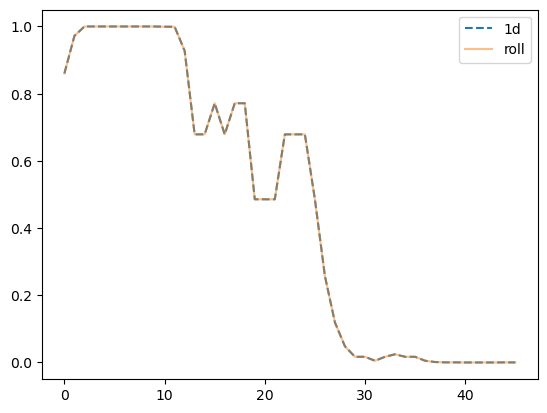

In [217]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

In [218]:
# def calculate_sn_from_s_and_n(signal_da:xr.DataArrray, noise_data:Union[float, xr.DataArray]
#                              ) -> xr.DataSet:

#     sn_da = signal_da/noise_data
    

<b> Hawkins S/N Ratio</b>

In [219]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_ds).compute()

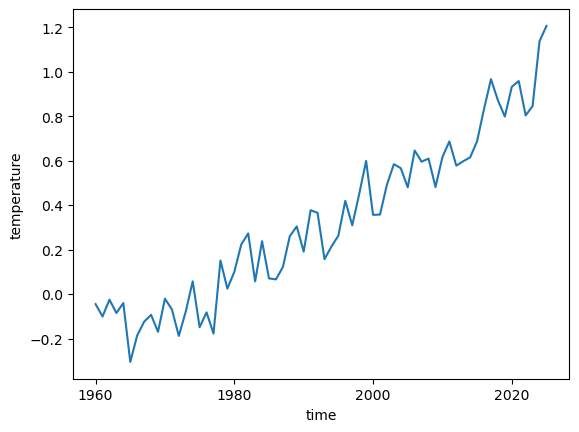

In [220]:
data_ds_smean.plot()

In [221]:
# Get lowess filtered version
ds_smean_lowess = stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [222]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

CPU times: user 3 s, sys: 1.12 s, total: 4.12 s
Wall time: 3.08 s


In [223]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [224]:
ds_signal_lowess = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()

In [225]:
# Noise series is detrended data
ds_noise_series_lowess = (data_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

### Plot Verificaiton

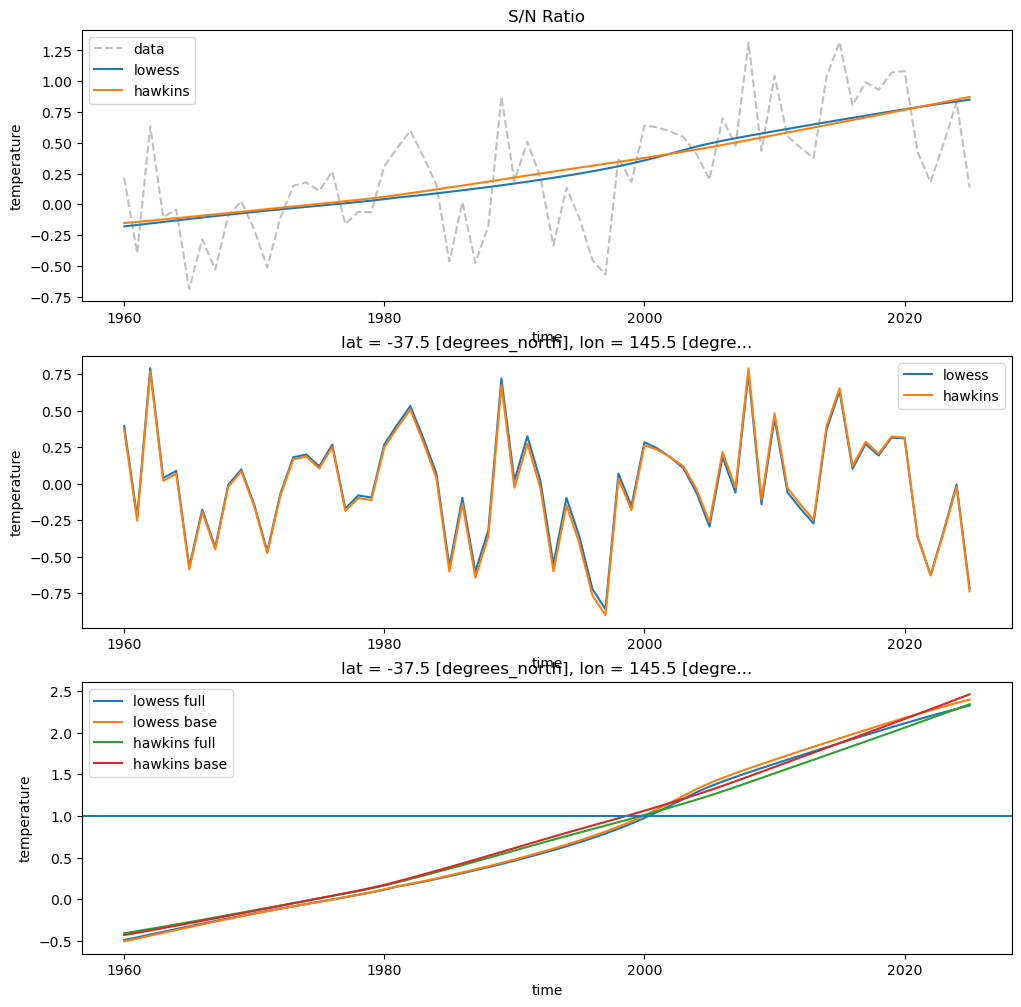

In [226]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ax1.set_title('Signal')
ax1.legend()

ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ax1.set_title('Noise Series')

ax2.legend()

ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)

ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax1.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

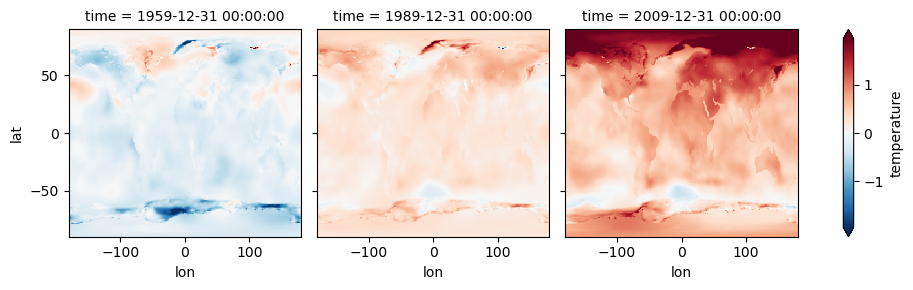

In [227]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [228]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [229]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [230]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [231]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [232]:
# ds_data_sn_lowess

In [233]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [234]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

In [235]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'

ks_ds.name = 'ks'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [236]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [237]:
toe_metrics_ds = xr.merge([ks_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 191MB
Dimensions:          (lat: 180, lon: 360, time: 46)
Coordinates:
  * lat              (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 1kB -179.5 -178.5 -177.5 ... 178.5 179.5
  * time             (time) object 368B 1969-12-31 00:00:00 ... 2014-12-31 00...
Data variables:
    ks               (time, lat, lon) float64 24MB 0.9993 0.9993 ... 2.122e-12
    perkins          (time, lat, lon) float64 24MB 80.0 80.0 ... 8.333 8.333
    frac             (time, lat, lon) float64 24MB 88.88 88.9 ... 9.034 9.016
    hd               (time, lat, lon) float64 24MB 18.17 18.18 ... 88.28 88.29
    sn_hawkins_full  (lat, lon, time) float64 24MB -0.08058 -0.06338 ... 2.845
    sn_hawkins_base  (lat, lon, time) float64 24MB -0.113 -0.08884 ... 3.127
    sn_lowess_full   (lat, lon, time) float64 24MB -0.09535 -0.06774 ... 3.135
    sn_lowess_base   (lat, lon, time) float64 24MB -0.1362 -0.09679 ... 3.729
Attributes: (1)

In [238]:
dataset_name, variable, base_period

('best', 'temperature', <YearRange.MODERN_PERIOD: (1959, 1989)>)

In [239]:
VAR_SAVE_DIR = os.path.join(constants.TOE_SAVE_DIR,
                            f'{dataset_name}_{variable}_({base_period.start}_{base_period.end})')
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_temperature_(1959_1989)'

In [240]:
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

In [241]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_ds.to_zarr(DATA_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_temperature_(1959_1989)/data.zarr


In [242]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins]) 
singal_ds

<xarray.Dataset> Size: 137MB
Dimensions:         (lat: 180, lon: 360, time: 66)
Coordinates:
  * lat             (lat) float32 720B -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 1kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time            (time) object 528B 1959-12-31 00:00:00 ... 2024-12-31 00:...
Data variables:
    signal_lowess   (lat, lon, time) float64 34MB -0.2682 -0.2471 ... 3.086
    noise_lowess    (time, lat, lon) float64 34MB 0.433 0.4325 ... -0.6452
    signal_hawkins  (lat, lon, time) float64 34MB -0.1714 -0.1605 ... 3.064
    noise_hawkins   (lat, lon, time) float64 34MB 0.3362 -0.4345 ... -0.6226

In [ ]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/best_temperature_(1959_1989)/signal.zarr


In [ ]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')